In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sea
%matplotlib inline

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.preprocessing import binarize
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn import metrics

In [3]:
import json

fn = 'RubygemDigger--Steps--GenerateJsonForLastVersions--3.data.json'
fn = 'RubygemDigger--Steps--GenerateJsonForLastVersions--6.data.json'
with open(fn) as f:
    d = json.load(f)

print(d[0])

n_obs = len(d)
print('nb_records:', n_obs)

{'label': 'good', 'stat': {'metrics_modulelength': 6, 'fun_count': 625, 'metrics_cyclomaticcomplexity': 3, 'metrics_methodlength': 5, 'metrics_classlength': 5, 'files': 56, 'lint_': 0, 'metrics_linelength': 8, 'nloc_rate': 0.24, 'fun_rate': 0.06, 'metrics_blocknesting': 0, 'warning_count': 35, 'metrics_abcsize': 9, 'metrics_blocklength': 3, 'avg_token': 37.2, 'metrics_parameterlists': 4, 'total': 4, 'avg_nloc': 6.9, 'metrics_perceivedcomplexity': 7, 'lint_duplicate': 1, 'style_': 4, 'nloc': 5601, 'avg_ccn': 1.7}, 'name': 'actionwebservice', 'version': '1.2.6'}
nb_records: 515


In [4]:
df = pd.io.json.json_normalize(d)

old_new_cols = {}
for name in df.columns:
    if name.startswith('stat'):
        old_new_cols[name] = name.split('.')[1]

df.rename(columns=old_new_cols, inplace=True)
df.head()

,label,name,avg_ccn,avg_nloc,avg_token,files,fun_count,fun_rate,lint_,lint_duplicate,...,metrics_methodlength,metrics_modulelength,metrics_parameterlists,metrics_perceivedcomplexity,nloc,nloc_rate,style_,total,warning_count,version
0,good,actionwebservice,1.7,6.9,37.2,56,625,0.06,0,1,...,5,6,4,7,5601,0.24,4,4,35,1.2.6
1,good,adlint,1.4,6.4,19.8,87,8007,0.03,1,0,...,1,6,2,3,62369,0.34,7,6,227,3.2.14
2,good,admin_assistant,1.8,6.5,29.1,33,414,0.05,5,0,...,8,1,1,1,3172,0.13,1,7,21,2.4.0
3,good,adwords4r,1.2,7.8,40.9,391,4054,0.01,4,1,...,6,5,5,0,151492,0.08,5,2,53,19.4.0
4,good,air18n,1.9,10.6,67.2,42,297,0.08,9,0,...,7,3,1,4,4249,0.27,8,7,24,0.5.1


In [5]:
rows_with_NaNs = pd.isnull(df).any(1).nonzero()[0]
print(df.ix[rows_with_NaNs][['name', 'version']])

Empty DataFrame
Columns: [name, version]
Index: []


In [6]:
print(df.shape)
if len(rows_with_NaNs) > 0:
    df.dropna(inplace=True)
    print(df.shape)

(515, 26)


In [7]:
exclude = ['avg_nloc',]
features = [k for k, v in d[0]['stat'].items() if k not in exclude]

X = df[features]
y = (df.label == 'good').values.astype(int)

In [8]:
def label_counts_summary(data, label='unknow'):
    N = len(data)
    N_ones = data.sum()
    print('''
label: {}
nb. of observations: {}
nb. of ones (good gems): {}
frequency: {:.3f}
    '''.format(label, N, N_ones, 1.0 * N_ones / N))

In [9]:
label_counts_summary(y, label='Full set')

# split full dataset into 70% training and 30% test data
# test data is used only to evalute the model's prediction performance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

label_counts_summary(y_train, label='Training set')
label_counts_summary(y_test, label='Test set')


label: Full set
nb. of observations: 515
nb. of ones (good gems): 154
frequency: 0.299
    

label: Training set
nb. of observations: 360
nb. of ones (good gems): 117
frequency: 0.325
    

label: Test set
nb. of observations: 155
nb. of ones (good gems): 37
frequency: 0.239
    


# Classify using LogisticRegression

In [10]:
model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(metrics.classification_report(y_test, y_pred))
print(metrics.accuracy_score(y_test, y_pred))  # % of correct predictions

             precision    recall  f1-score   support

          0       0.76      0.90      0.82       118
          1       0.20      0.08      0.12        37

avg / total       0.62      0.70      0.65       155

0.703225806452


In [11]:
# generate predictions based on classification probability
y_pred_proba = model.predict_proba(X_test)

print(y_pred_proba[:3])

thresh = 0.6
y_pred_good = binarize([y_pred_proba[:,1]], thresh)[0]

print(metrics.accuracy_score(y_test, y_pred_good))

[[ 0.43586084  0.56413916]
 [ 0.79044508  0.20955492]
 [ 0.71079793  0.28920207]]
0.761290322581


## k-fold cross-validation

Split data into 10 blocks and use 1 as testing and 9 others as training. Repeat 10 times with different block as testing block. Good for verifying dependency on outliers.

In [12]:
model = LogisticRegression()
scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
print(scores)
print(scores.mean(), scores.std())

[ 0.66037736  0.69230769  0.69230769  0.69230769  0.68627451  0.74509804
  0.66666667  0.68627451  0.68627451  0.7254902 ]
0.693337886679 0.0237980935491


# Classify using kNN

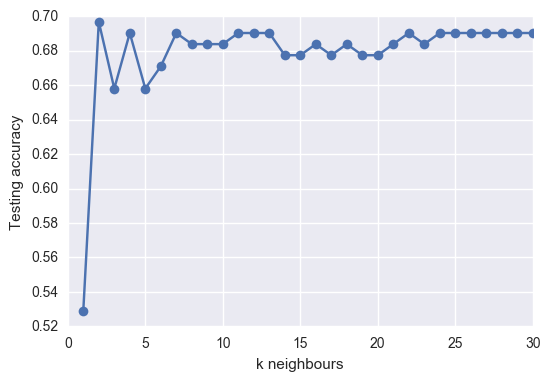

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

nb_range = np.arange(1, 31)
a_scores = []

for nb in nb_range:
    model = KNeighborsClassifier(n_neighbors=nb)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    a_scores.append(metrics.accuracy_score(y_test, y_pred))
    
plt.plot(nb_range, a_scores, 'o-')
plt.ylabel('Testing accuracy')
plt.xlabel('k neighbours')

In [14]:
from sklearn.grid_search import GridSearchCV

In [15]:
k_range = list(range(1, 31))
weight_options = ['uniform', 'distance']
param_grid = dict(n_neighbors=k_range, weights=weight_options)

knn = KNeighborsClassifier()

grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)


# examine the best model
print(grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

0.702912621359
{'weights': 'uniform', 'n_neighbors': 12}
KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=12, p=2,
           weights='uniform')
